# 3. Basic model from scratch

## Prerequisites

  - Install Conda and create environment: see notebook *1. Conda setup*
  - Install Poetry and create configuration: see notebook *2. Poetry setup*

Make sure you select the environment (kernel) *NN* to run this notebook. Also activate it in companion terminal:  
`conda activate NN`

Let's check we have Python 3.9 running:

In [1]:
!python --version

Python 3.9.7


Let's make sure packages and dependencies are installed by Poetry:  
```poetry install```

Let's check our packages and dependencies:

In [2]:
!poetry show --tree

matplotlib 3.5.1 Python plotting package
├── cycler >=0.10
├── fonttools >=4.22.0
├── kiwisolver >=1.0.1
├── numpy >=1.17
├── packaging >=20.0
│   └── pyparsing >=2.0.2,<3.0.5 || >3.0.5 
├── pillow >=6.2.0
├── pyparsing >=2.2.1
├── python-dateutil >=2.7
│   └── six >=1.5 
└── setuptools-scm >=4
    ├── packaging >=20.0 
    │   └── pyparsing >=2.0.2,<3.0.5 || >3.0.5 
    └── tomli >=1.0.0 
numpy 1.22.1 NumPy is the fundamental package for array computing with Python.
pytest 6.2.5 pytest: simple powerful testing with Python
├── atomicwrites >=1.0
├── attrs >=19.2.0
├── colorama *
├── iniconfig *
├── packaging *
│   └── pyparsing >=2.0.2,<3.0.5 || >3.0.5 
├── pluggy >=0.12,<2.0
├── py >=1.8.2
└── toml *
torch 1.10.1 Tensors and Dynamic neural networks in Python with strong GPU acceleration
└── typing-extensions *


If we want to update the Conda environment, we can run (in companion terminal):  
```
conda env update --prune -f environment_init.yml
```

If we want to update the Poetry setup, we can run (in companion terminal, making sure NN is activated):  
```
poetry update
```

We can create shortcuts for these actions in a separate **Makefile** (check its contents), which can then be called from a terminal:
```
make conda-udate
make poetry-update
```

## Linear model

Note: This notebook is inspired from https://fullstackdeeplearning.com/spring2021/notebook-1/.

### Generate and visualize data

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Let us create and show a dataset of 20 points:

In [4]:
nb_datapoints = 10
input_dim = 1
x = np.random.uniform(-1, 1, (nb_datapoints, input_dim))
x.sort(axis=0)

Suppose that we want to approximate the 'true' function \bar{f}(x) = x/2 + 1:


In [5]:
output_dim = 1

weights_true = np.random.uniform(-1, 1, (input_dim, output_dim))
bias_true = np.random.uniform(-1, 1, (output_dim,))

y_true = x @ weights_true + bias_true # Matrix multiplication and element-wise addition

Let's inspect all the shapes:

In [6]:
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y_true: {y_true.shape}')

x: (10, 1), weights: (1, 1), bias: (1,), y_true: (10, 1)


Let's plot our true function:

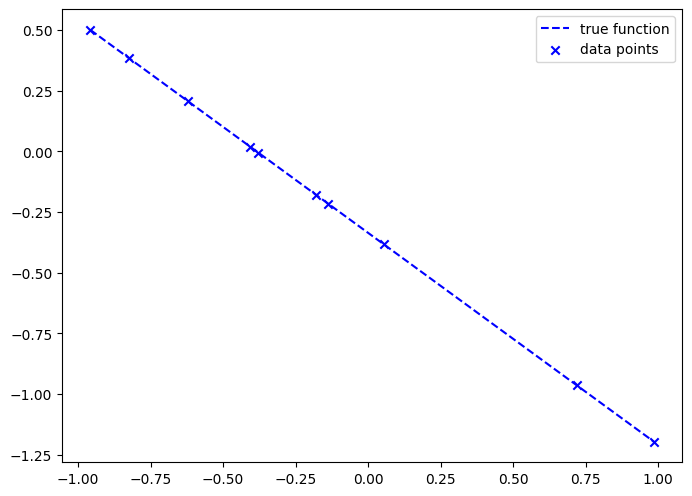

In [7]:
from matplotlib.pyplot import figure


figure(figsize=(8, 6), dpi=100)
plt.plot(x.squeeze(-1), y_true.squeeze(-1), 'b--', label='true function')
plt.scatter(x.squeeze(-1), y_true.squeeze(-1), color='b', marker='x', label='data points')
plt.legend()
plt.show()

### Linear model

Let us define the simplest model: one layer, linear, no activation function. This is equivalent to linear regression.

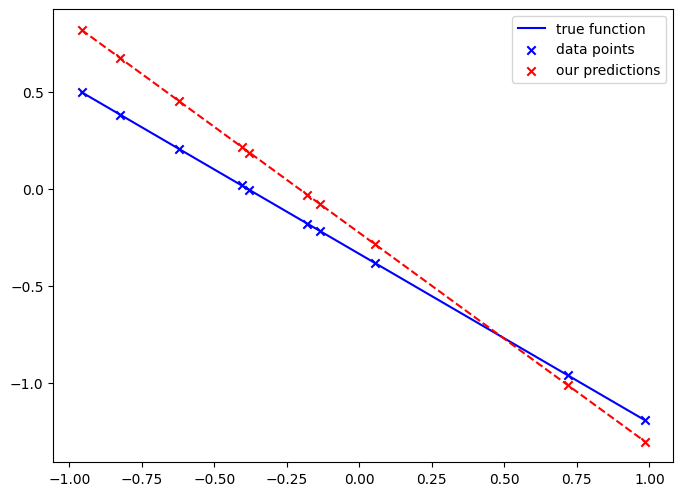

In [8]:
class LinearLayer:
  def __init__(self, input_dim, output_dim):
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(1. / input_dim) # Not sure why FSDL had np.sqrt(2. / input_dim)
    # It is best to think of the weights as a matrix acting on the input (given as a line vector) by multiplication *on the right*
    self.bias = np.random.randn(output_dim) * np.sqrt(1. / input_dim) # FSDL initializes them to zero: np.zeros(output_dim)
  
  def __call__(self, x):
    return x @ self.weights + self.bias
  # Mind that the first dim of x corresponds to the number of data points.
  # In numpy, when doing matrix multiplication, if either argument is N-dimensional, N > 2, 
  # then it is treated as a stack of matrices residing in the last two indexes.

  def weights_gradient(self, x):
    return x

  def bias_gradient(self, x):
    return np.identity(self.output_dim)
    

linear = LinearLayer(1, 1)
y_pred = linear(x)
figure(figsize=(8, 6), dpi=100)
plt.plot(x.squeeze(-1), y_true.squeeze(-1), 'b-', label='true function')
plt.scatter(x.squeeze(-1), y_true.squeeze(-1), color='b', marker='x', label='data points')
plt.plot(x.squeeze(-1), y_pred.squeeze(-1), 'r--')
plt.scatter(x.squeeze(-1), y_pred.squeeze(-1), color='r', marker='x', label='our predictions')
plt.legend()
plt.show()

Basic metric: MSE


In [9]:
class MSE:
  def __call__(self, y, y_true):
    return ((y - y_true) ** 2).mean()

  def gradient(self, y, y_true):
    return 2. * (y - y_true) / y.shape[0]

  
metric = MSE()
print(f'Our initial loss is {metric(y_pred, y_true)}')

Our initial loss is 0.03926483261302051


Let's now create our model:

In [10]:
class LinearModel:
    def __init__(self, layer, metric):
        self.layer = layer
        self.metric = metric

    def __call__(self, x):
        return self.layer(x)

    def forward_pass(self, x):
        self.x = x
        self.y = self(x)

    def loss(self, x, y_true):
        return self.metric(self(x), y_true)

    def back_propagate(self, y_true, learning_rate):
        weights_gradient = self.layer.weights_gradient(self.x)[:, None] # shape (nb_datapoints, input_dim, 1)
        metric_gradient = self.metric.gradient(self.y, y_true)[:, None] # shape (nb_datapoints, output_dim, 1)
        self.weights_gradient = (weights_gradient @ metric_gradient.transpose(0,2,1)) #shape (nb_datapoints, input_dim, output_dim)
        self.weights_gradient = self.weights_gradient.mean(axis=0) #shape (input_dim, output_dim)
        self.layer.weights = self.layer.weights - learning_rate*self.weights_gradient

        bias_gradient = self.layer.bias_gradient(self.x) # shape (output_dim, output_dim)
        self.bias_gradient = (bias_gradient.T @ metric_gradient) # shape (nb_datapoints, output_dim, 1)
        self.bias_gradient = (bias_gradient.T @ metric_gradient).squeeze(-1) #shape (nb_datapoints, ouput_dim)
        self.bias_gradient = self.bias_gradient.mean(axis=0) #shape (output_dim,)
        self.layer.bias = self.layer.bias - learning_rate*self.bias_gradient

Let's try it! Observe that the loss decreases after one forward and backward pass.

In [11]:

def fbar(x):
    return x @ weights_true + bias_true

x = np.random.uniform(-1, 1, (10, 1))
y_true = fbar(x)

linear = LinearLayer(1, 1)
metric = MSE()
model = LinearModel(linear, metric)

print(f"loss = {model.loss(x, y_true)}")

model.forward_pass(x)
model.back_propagate(y_true, 1.)
print(f"loss = {model.loss(x, y_true)}")

loss = 0.9788335410853073
loss = 0.8002612311112995


Let's add some bells and whistles:

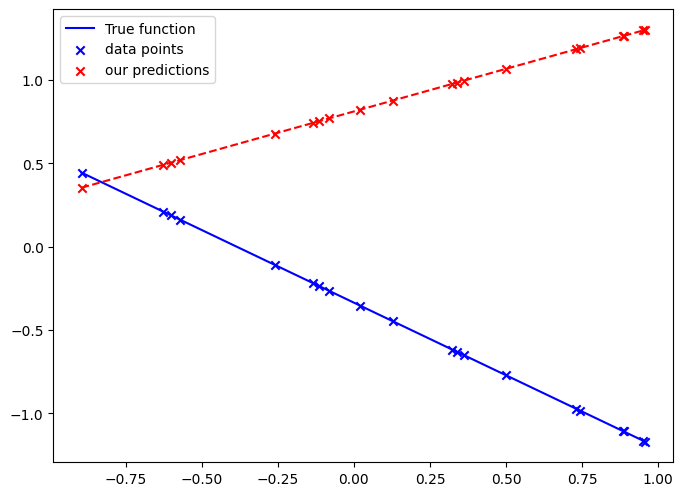

Epoch 1: loss = 0.5369207881520282
Epoch 2: loss = 0.16620403097685627
Epoch 3: loss = 0.07481462588044532
Epoch 4: loss = 0.041402415969173795
Epoch 5: loss = 0.0245195964467484
Epoch 6: loss = 0.01438086154536257
Epoch 7: loss = 0.008489278575998797
Epoch 8: loss = 0.005055761116412519
Epoch 9: loss = 0.003023459352088964
Epoch 10: loss = 0.0018053041575487982
Epoch 11: loss = 0.0010676442330343266
Epoch 12: loss = 0.0006307761725507711
Epoch 13: loss = 0.0003783737237946879
Epoch 14: loss = 0.00022621959098866667
Epoch 15: loss = 0.00013496360186231242
Epoch 16: loss = 8.016255920616826e-05
Epoch 17: loss = 4.71115777142136e-05
Epoch 18: loss = 2.799326783228038e-05
Epoch 19: loss = 1.6625303959869875e-05
Epoch 20: loss = 9.896446135339556e-06


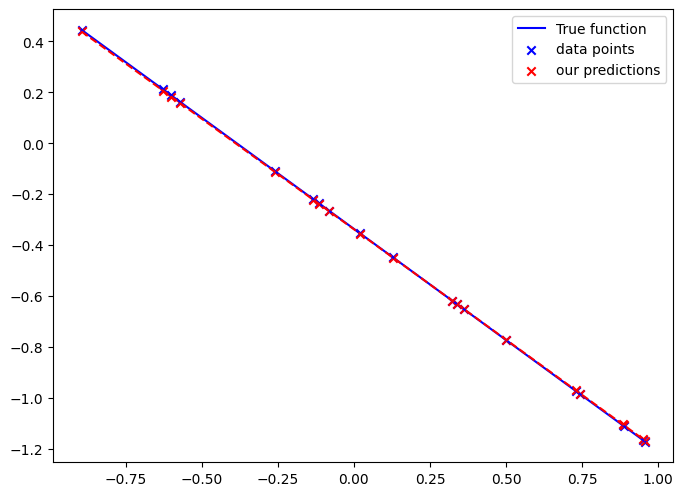

In [36]:
class LinearModel:
    def __init__(self, layer, metric):
        self.layer = layer
        self.metric = metric

    def __call__(self, x):
        return self.layer(x)

    def forward_pass(self, x):
        self.x = x
        self.y = self(x)

    def training_loss(self):
        return self.metric(self(self.x_training), self.y_true_training)

    def back_propagate(self, y_true, learning_rate):
        weights_gradient = self.layer.weights_gradient(self.x)[:, None] # shape (nb_datapoints, input_dim, 1)
        metric_gradient = self.metric.gradient(self.y, y_true)[:, None] # shape (nb_datapoints, output_dim, 1)
        self.weights_gradient = (weights_gradient @ metric_gradient.transpose(0,2,1)) #shape (nb_datapoints, input_dim, output_dim)
        self.weights_gradient = self.weights_gradient.mean(axis=0) #shape (input_dim, output_dim)
        self.layer.weights = self.layer.weights - learning_rate*self.weights_gradient

        bias_gradient = self.layer.bias_gradient(self.x) # shape (output_dim, output_dim)
        self.bias_gradient = (bias_gradient.T @ metric_gradient) # shape (nb_datapoints, output_dim, 1)
        self.bias_gradient = (bias_gradient.T @ metric_gradient).squeeze(-1) #shape (nb_datapoints, ouput_dim)
        self.bias_gradient = self.bias_gradient.mean(axis=0) #shape (output_dim,)
        self.layer.bias = self.layer.bias - learning_rate*self.bias_gradient

    def set_training_data(self, x_training,):
        self.x_training = x_training
        self.nb_datapoints = x_training.shape[0]

    def set_training_labels(self, y_true_training=None, true_function=None):
            assert((y_true_training is None) ^ (true_function is None))
            if true_function:
                y_true_training = true_function(self.x_training)
            self.y_true_training = y_true_training

    def set_training_parameters(self, batch_size=5, learning_rate=0.1):
        self.batch_size = batch_size
        self.learning_rate = learning_rate

    def train(self, nb_epochs):
        x_training = np.copy(self.x_training)
        y_true_training = np.copy(self.y_true_training)

        for epoch in range(1, nb_epochs+1):
            seed = np.random.randint(0, 2**(32 - 1) - 1)
            rstate = np.random.RandomState(seed)
            rstate.shuffle(x_training)
            rstate = np.random.RandomState(seed)
            rstate.shuffle(y_true_training)
            
            k=0
            while k+self.batch_size <= self.nb_datapoints:
                x_batch = x_training[k:k+self.batch_size]
                y_true_batch = y_true_training[k:k+self.batch_size]
                self.forward_pass(x_batch)
                self.back_propagate(y_true_batch, self.learning_rate)
                k += self.batch_size
            if k<self.nb_datapoints:
                x_batch = x_training[k:]
                y_true_batch = y_true_training[k:]
                self.forward_pass(x_batch)
                self.back_propagate(y_true_batch, self.learning_rate)

            if epoch % 1 ==0:
                print(f"Epoch {epoch}: loss = {self.training_loss()}")

    def plot(self): # Only works if target is 1D
        y_pred = model(self.x_training)
        y_true = self.y_true_training

        figure(figsize=(8, 6), dpi=100)
        plt.plot(x, y_true, 'b-', label='True function')
        plt.scatter(x, y_true, color='b', marker='x', label='data points')
        plt.plot(x.squeeze(-1), y_pred.squeeze(-1), 'r--')
        plt.scatter(x, y_pred, color='r', marker='x', label='our predictions')
        plt.legend()
        plt.show()



def fbar(x):
    return x @ weights_true + bias_true

x = np.random.uniform(-1, 1, (20, 1))
x.sort(axis=0)

linear = LinearLayer(1, 1)
metric = MSE()
model = LinearModel(linear, metric)
model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(batch_size=5, learning_rate=0.5)


model.plot()
model.train(20)
model.plot()

Let's try to approximate a non-linear function:

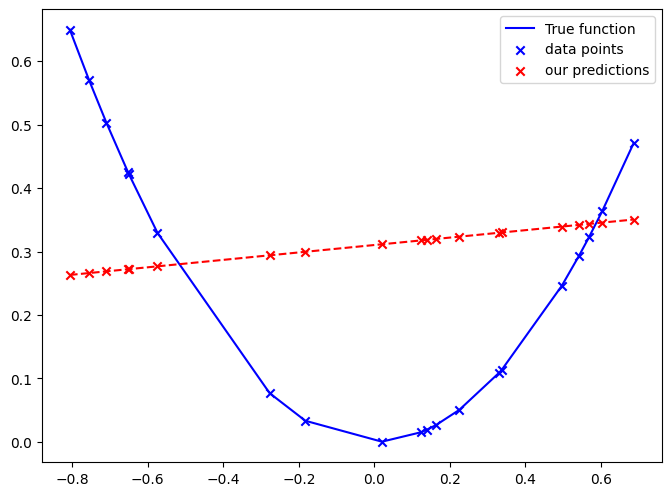

Epoch 1: loss = 0.04923000207071534
Epoch 2: loss = 0.04760154796718378
Epoch 3: loss = 0.04621816836983115
Epoch 4: loss = 0.045031155113463006
Epoch 5: loss = 0.04400572057784985
Epoch 6: loss = 0.04307849217559999
Epoch 7: loss = 0.04230336818801917
Epoch 8: loss = 0.04160057488119188
Epoch 9: loss = 0.040965117319098604
Epoch 10: loss = 0.040399887592965505
Epoch 11: loss = 0.03988399295516164
Epoch 12: loss = 0.039408293789770364
Epoch 13: loss = 0.03898825449735541
Epoch 14: loss = 0.038595138164709865
Epoch 15: loss = 0.03823611738585271
Epoch 16: loss = 0.03790808905012051
Epoch 17: loss = 0.03760996665025234
Epoch 18: loss = 0.03733528277553643
Epoch 19: loss = 0.03707927152704801
Epoch 20: loss = 0.03684765539639474


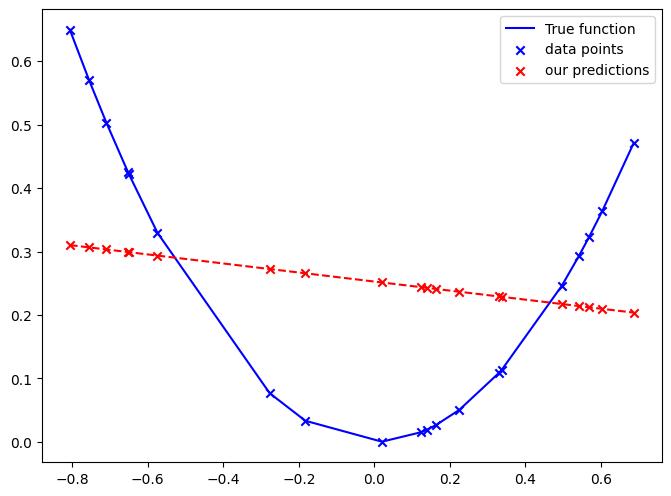

In [38]:
def fbar(x):
    return x ** 2

x = np.random.uniform(-1, 1, (20, 1))
x.sort(axis=0)

model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(learning_rate=0.1)


model.plot()
model.train(20)
model.plot()

### 2-dimensional inputs work too

In [63]:

nb_datapoints = 100
input_dim = 2
output_dim = 1
x = np.random.uniform(-1, 1, (nb_datapoints, input_dim, output_dim))

weights_true = np.array([[2, -1], ]).T
bias_true = np.array([0.5])

print(x.shape)
print(weights_true.shape)

def fbar(x):
  return x @ weights_true + bias_true

y_true = fbar(x)

def plot_3d(x, y, y_pred=None):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y, label='underlying function')
  #if y_pred is not None:
  #  ax.scatter(x[:, 0], x[:, 1], y_pred, label='our function')
  plt.legend()
  plt.show()

plot_3d(x, y_true)

(100, 2, 1)
(2, 1)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 1)

In [ ]:
loss = MSE()
linear = Linear(2)
y_pred = linear(x)
print(loss(y_pred, y_true))
fig = plot_3d(x, y_true, y_pred)

In [ ]:
from typing import Callable

def fit(x: np.ndarray, y: np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)

fit(x, y_true, model=linear, loss=loss, lr=0.1, num_epochs=20)
plot_3d(x, y_true, linear(x))

## Basic regression with a Multi-layer Perceptron

So, we now have a way to automatically fit a linear function to N-dimensional data.

How can this be made to work for non-linear data?

In [ ]:
# Make non-linear data

n = 200
d = 2
x = np.random.uniform(-1, 1, (n, d))

weights_true = np.array([[5, 1],]).T
bias_true = np.array([1])

y_true = (x ** 2) @ weights_true + x @ weights_true + bias_true
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

plot_3d(x, y_true)

In [ ]:
# We can train just fine, but the final loss will remain high, as our linear function is incapable
# of representing the data.

loss = MSE()
linear = Linear(d)
fit(x, y_true, model=linear, loss=loss, lr=0.1, num_epochs=40)
plot_3d(x, y_true, linear(x))

### Add non-linearity: ReLU

In [ ]:
# In order to learn non-linear functions, we need non-linearities in our model.

class Relu:
    def __call__(self, input_):
        self.input_ = input_
        self.output = np.clip(self.input_, 0, None)
        return self.output
    
    def backward(self, output_gradient):
      # import pdb; pdb.set_trace()  # By the way, this is how you can debug
      self.input_gradient = (self.input_ > 0) * output_gradient
      return self.input_gradient


relu = Relu()
input_ = np.expand_dims(np.array([1, 0.5, 0, -0.5, -1]), -1)
print(relu(input_))
print(relu.backward(input_))

### Train our new non-linear model

In [ ]:
class Model:
  def __init__(self, input_dim, num_hidden):
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu = Relu()
    self.linear2 = Linear(num_hidden, 1)
  
  def __call__(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2
  
  def backward(self, output_gradient):
    linear2_gradient = self.linear2.backward(output_gradient)
    relu_gradient = self.relu.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu_gradient)
    # print('Model backward', linear2_gradient.shape, relu_gradient.shape, linear1_gradient.shape)
    # import pdb; pdb.set_trace()
    return linear1_gradient

  def update(self, lr):
    self.linear2.update(lr)
    self.linear1.update(lr)

loss = MSE()
model = Model(d, 10)
y_pred = model(x)
loss_value = loss(y_pred, y_true)
loss_gradient = loss.backward()
print(loss_value)
model.backward(loss_gradient)
plot_3d(x, y_true, y_pred)

In [ ]:
# Test just one forward and backward step
loss = MSE()
model = Model(d, 10)
y_pred = model(x)
loss_value = loss(y_pred, y_true)
print(loss_value)
loss_gradient = loss.backward()
model.backward(loss_gradient)
model.update(0.1)
y_pred = model(x)
loss_value = loss(y_pred, y_true)
print(loss_value)

In [ ]:
fit(x, y_true, model=model, loss=loss, lr=0.1, num_epochs=40)
plot_3d(x, y_true, model(x))

### Same thing, in PyTorch

In [ ]:
import torch
import torch.nn as nn


class TorchModel(nn.Module):
  def __init__(self, input_dim, num_hidden):
    super().__init__()
    self.linear1 = nn.Linear(input_dim, num_hidden)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(num_hidden, 1)
  
  def forward(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2


loss = nn.MSELoss()
model = TorchModel(d, 10)
x_tensor = torch.tensor(x).float()
y_true_tensor = torch.tensor(y_true).float()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

In [ ]:
# Test just one forward and backward step
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

optimizer.zero_grad()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)
loss_gradient = loss_value.backward()
optimizer.step()

y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

In [ ]:
# Now we run the training loop

def torch_fit(x: np.ndarray, y: np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int):
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred_tensor = model(x_tensor)
    loss_value = loss(y_pred_tensor, y_true_tensor)
    print(loss_value)
    loss_value.backward()
    optimizer.step()

torch_fit(x_tensor, y_true_tensor, model=model, loss=loss, lr=0.1, num_epochs=40)
plot_3d(x, y_true, model(x_tensor).detach())

### Same thing, in Tensorflow/Keras

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

inputs = keras.Input(shape=(2,))
l1 = layers.Dense(10, activation='relu', name='dense_1')(inputs)
outputs = layers.Dense(1, name='regression')(l1)

model = keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())
model.compile(loss='mse', optimizer=optimizers.SGD(0.1))

model.fit(x, y_true, epochs=10)

y_pred = model.predict(x)

plot_3d(x, y_true, model(x))